#  Task 2: Extract prevalent topics from Twitter messages

## 🎯 Objective

- The goal of this project is to **extract the most frequent topics** discussed in tweets related to a specific city or region using **Natural Language Processing (NLP)** techniques.
- This analysis helps identify **trends, public concerns, and popular discussions** by processing tweet content.
- The insights can support **local researchers, journalists, or policymakers** by showing what people are actively talking about in a particular location.

## Diagram of the project

![ScholarAI Diagram](https://i.postimg.cc/jj4GrYzg/Diagram-1.png)

# Notebook Installations

In [1]:
!pip install -qU tweepy

In [2]:
import tweepy
import time
import pandas as pd
from kaggle_secrets import UserSecretsClient

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from IPython.display import HTML
import pandas as pd
from tweepy.errors import TooManyRequests
import pandas as pd
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
user_secrets = UserSecretsClient()
# access_token = user_secrets.get_secret("access_token")
# access_token_secret = user_secrets.get_secret("access_token_secret")
bearer_token = user_secrets.get_secret("BEARER_TOKEN")
# consumer_key = user_secrets.get_secret("consumer_key")
# consumer_secret = user_secrets.get_secret("consumer_secret")

## Step 1: Data Collection

I used the **Twitter API v2** to collect recent tweets related to Uzbekistan by searching for keywords like **"Tashkent"**, **"Uzbekistan"**, and **#Uzbekistan.** Since I don't have access to location-based filters, I relied on these keywords along with the language filter **lang:en** to get relevant tweets.

I fetched tweets in multiple batches using **Tweepy**, with a delay between requests to respect the rate limit. Each tweet includes the text, author ID, language, creation time, and context annotations (if available).

In [5]:
client = tweepy.Client(bearer_token=bearer_token)

In [6]:
# Pre-define df in case all branches fail
df = None

query = (
    "(Tashkent OR Uzbekistan OR #Uzbekistan OR #Tashkent OR Samarqand OR Samarkand) "
    "-is:retweet lang:en"
)

try: 
    tweet = client.search_recent_tweets(
        query=query,
        tweet_fields=['context_annotations', 'created_at', 'author_id', 'lang'],
        max_results=100
    )

    if tweet.data is not None:
        tweet_list = []
        for t in tweet.data:
            tweet_list.append({
                "id": t.id,
                "text": t.text,
                "created_at": t.created_at,
                "author_id": t.author_id,
                "lang": t.lang,
                "context_annotations": t.context_annotations if hasattr(t, "context_annotations") else None
            })

        df = pd.DataFrame(tweet_list)
        print(df.head())
    else:
        print("No tweets returned.")

except TooManyRequests:
    print("Twitter API limit reached. Loading fallback CSV...")
    df = pd.read_csv("/kaggle/input/2024-us-presidential-elections-twitter-data/final_raw.csv")
    print(df.head())

finally:
    if df is not None:
        df.to_csv('submission.csv', index=False)

        def create_download_link(title="Download CSV file", filename="submission.csv"):  
            html = f'<a href="{filename}">{title}</a>'
            return HTML(html)

        create_download_link(filename='submission.csv')
    else:
        print("No DataFrame available to save.")

Twitter API limit reached. Loading fallback CSV...
              Tweet ID            Username  \
0  1798142586911342936          Rabbit1873   
1  1798142575112769914      Chrissi Miller   
2  1798142544762830918  Pedro Da Conceicao   
3  1798142432388714849              Ben 🇺🇲   
4  1798142320958943735  🇺🇸Proud American🇮🇹   

                                                Text  \
0  @JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...   
1  @PaulStanleyLive #PresidentDonaldTrump wins th...   
2  @tomorrowsmps I believe I am the youngest PPC ...   
3  I am already saying Democrats will cheat even ...   
4  @BryanDeanWright Republican AG’s should prosec...   

                             Date  Retweets  Likes    Weight  
0  Tue Jun 04 23:59:35 +0000 2024         2      3  0.622459  
1  Tue Jun 04 23:59:32 +0000 2024         0      0  0.622459  
2  Tue Jun 04 23:59:25 +0000 2024         0      0  0.982014  
3  Tue Jun 04 23:58:58 +0000 2024         0      0  0.500000  
4  Tue Jun 04 23:58:

In [7]:
df.shape

(26425, 7)

In [8]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


In [9]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
Tweet ID    0
Username    2
Text        0
Date        0
Retweets    0
Likes       0
Weight      0
dtype: int64


In [10]:
print(f"The types of the data: \n{df.dtypes}\n")

The types of the data: 
Tweet ID      int64
Username     object
Text         object
Date         object
Retweets      int64
Likes         int64
Weight      float64
dtype: object



In [11]:
df.drop_duplicates('Text', inplace=True)
print(df.shape)
df.head()

(26314, 7)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


## Step 2: Data Preprocessing


* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.


In [12]:
# remove html tags from text
def remove_html_tags(text):
    """
    Remove HTML tags from a given string.

    Parameters:
        text (str): The input string containing HTML tags.

    Returns:
        str: The cleaned string with HTML tags removed.
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [13]:
def clean_review(text, wl=WordNetLemmatizer(), 
                 stop_words=set(stopwords.words('english'))):
    """
    Clean and preprocess a text string for NLP analysis.

    This function performs several preprocessing steps:
    - Removes HTML tags
    - Converts text to lowercase
    - Tokenizes the text
    - Removes stopwords and non-alphabetic tokens
    - Applies lemmatization

    Parameters:
        text (str): The input text string to be cleaned.
        wl (WordNetLemmatizer, optional): Lemmatizer instance. Defaults to WordNetLemmatizer().
        stop_words (set, optional): Set of stopwords to remove. Defaults to English stopwords from NLTK.

    Returns:
        str: The cleaned and lemmatized text string.
    """
    cleaned_text = remove_html_tags(text)
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
    return filtered_words

In [14]:
print(df.columns)

Index(['Tweet ID', 'Username', 'Text', 'Date', 'Retweets', 'Likes', 'Weight'], dtype='object')


In [15]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


In [16]:
%%time
import re

# Apply the `clean_review` function to each tweet
df['Clean text'] = df['Text'].apply(clean_review)
df.head()

CPU times: user 11.1 s, sys: 350 ms, total: 11.5 s
Wall time: 11.5 s


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Clean text
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,jackposobiec breaking garland launch threat ta...
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,paulstanleylive presidentdonaldtrump win presi...
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,tomorrowsmps believe youngest ppc standing ele...
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,already saying democrat cheat even keep beggin...
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,bryandeanwright republican ag prosecute intell...


In [17]:
df.drop_duplicates('Clean text', inplace=True) 
df.reset_index(drop=True, inplace=True)

In [18]:
print(df.shape)
df.head()

(25652, 8)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Clean text
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,jackposobiec breaking garland launch threat ta...
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,paulstanleylive presidentdonaldtrump win presi...
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,tomorrowsmps believe youngest ppc standing ele...
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,already saying democrat cheat even keep beggin...
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,bryandeanwright republican ag prosecute intell...


## **Step 3: Entity Analysis**

* **Hashtag**: Extracted all words starting with #, counted their frequency, and visualized the top 10 most used hashtags.
* **Mentions:** Extracted all mentions (@username) from tweet text, counted their occurrences, and visualized the top 10 most mentioned users.
* **Active Users:** Identified tweet authors from the Username field, ranked users by number of tweets, and plotted the top 10 most active users.

### Hashtags

In [19]:
# function to print all the hashtags in a text
def extract_hashtags(text):
    return [word[1:] for word in text.split() if word.startswith('#')]

In [20]:
hashtag_list = []
for i in range(len(df['Text'])):
    hashtags = extract_hashtags(df['Text'][i])
    if len(hashtags) != 0:
        hashtag_list.append(hashtags)

hashtag_list[:5]

[['PresidentDonaldTrump'],
 ['मोदी_चूरचूर_लड्डू'],
 ['GoogleAlerts'],
 ['GoogleAlerts'],
 ['GoogleAlerts']]

In [21]:
# flatten the list of hashtag lists
flat_hashtag_list = [hashtag.lower() for sublist in hashtag_list for hashtag in sublist]

# count the hashtags
hashtag_counts = Counter(flat_hashtag_list)

# get the top 10 most common hashtags
top_10_hashtags = hashtag_counts.most_common(10)

for tag, count in top_10_hashtags:
    print(f"#{tag}: {count}")

#trump: 110
#maga: 82
#trump2024: 69
#smartnews: 44
#kamalaharris: 44
#biden: 43
#election2024: 39
#donaldtrump: 37
#election: 25
#democrat: 25


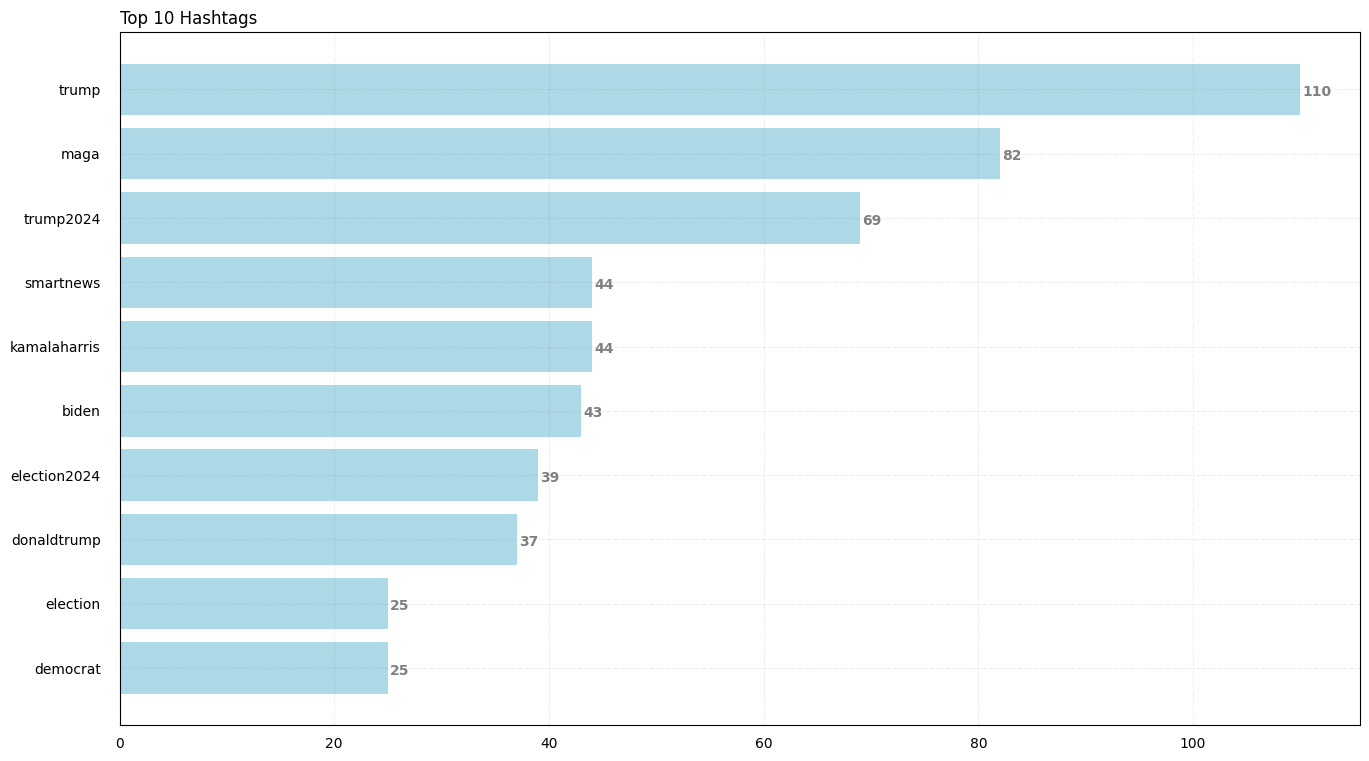

In [22]:
hashtags = [top_10_hashtags[i][0] for i in range(len(top_10_hashtags))]
count_hashtags = [top_10_hashtags[i][1] for i in range(len(top_10_hashtags))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(hashtags, count_hashtags, color='lightblue')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Hashtags', loc='left')

# Show Plot
plt.show()

### Mentions

In [23]:
# function to print all the users mentioned in a tweet
def extract_users(text):
    return [word[1:] for word in text.split() if word.startswith('@')]

In [24]:
users = [extract_users(text) for text in df['Text'] if extract_users(text)]
users[:5]

[['JackPosobiec'],
 ['PaulStanleyLive'],
 ['tomorrowsmps'],
 ['BryanDeanWright'],
 ['WashTimes']]

In [25]:
# flatten the list of users
flat_users_list = [hashtag.lower() for sublist in users for hashtag in sublist]

# count the users
user_counts = Counter(flat_users_list)

# get the top 10 most common users
top_10_users = user_counts.most_common(10)

for tag, count in top_10_users:
    print(f"@{tag}: {count}")

@mike_pence: 738
@youtube: 470
@elonmusk: 392
@realdonaldtrump: 371
@kamalaharris: 360
@robertkennedyjr: 277
@harris_wins: 184
@vivekgramaswamy: 178
@gunthereagleman: 152
@jdvance: 149


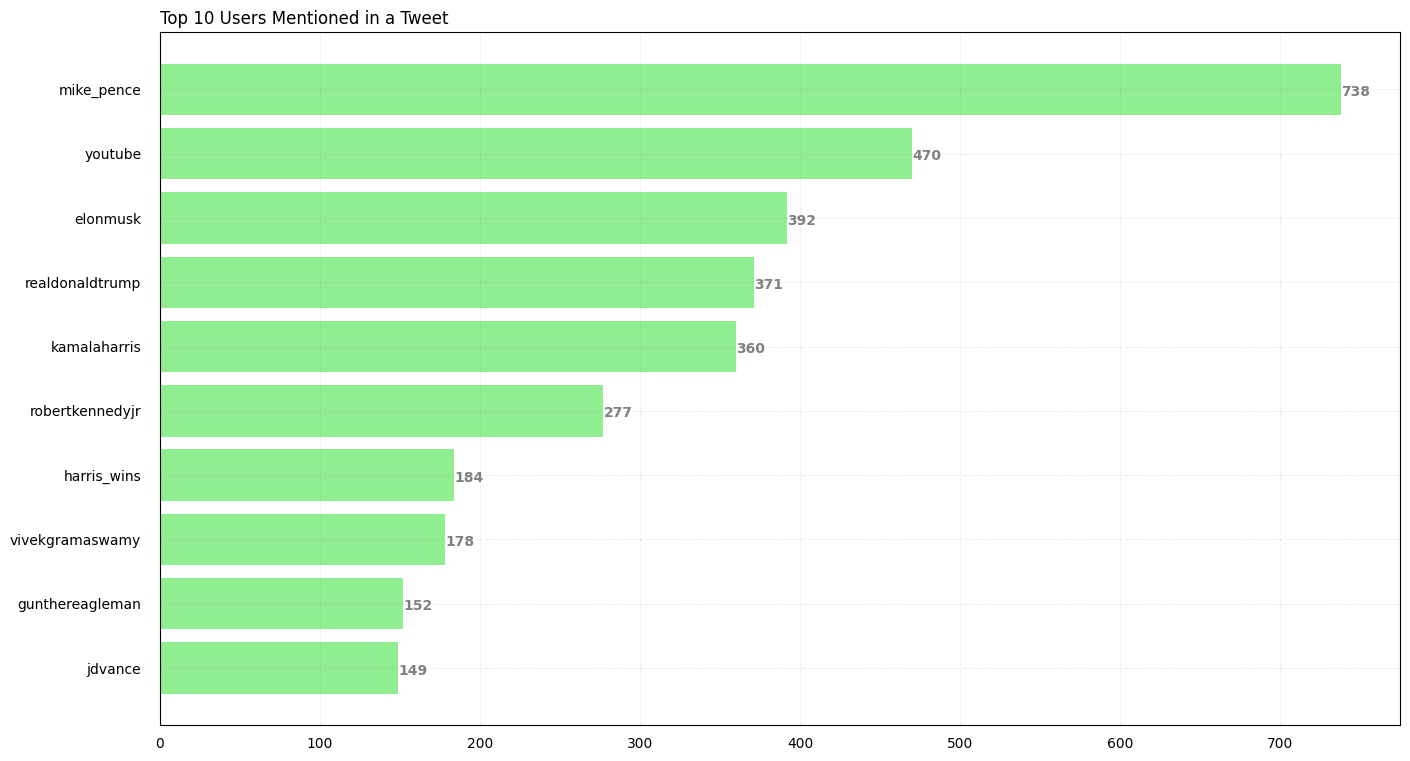

In [26]:
users = [top_10_users[i][0] for i in range(len(top_10_users))]
count_users = [top_10_users[i][1] for i in range(len(top_10_users))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(users, count_users, color='lightgreen')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Users Mentioned in a Tweet', loc='left')

# Show Plot
plt.show()

### Active Users

In [27]:
df['Username'].value_counts()[:10]

Username
HaleyFan 🇵🇸                             137
Vivek G. Ramaswamy - Commentary News    126
Mike Pence's Other Mother 🟧🟦🟪            87
RFK Jr's brain worm 🪱                    85
Vivek Ramaswamy                          49
MA for RFK Jr                            34
Richard Smit 🦅🚁💰🇳🇱🇺🇸🇬🇧🇮🇱🇺🇦🇹🇼             30
𝐁𝐄𝐀𝐒𝐓 ᴰᴱᴹᴼᶜᴿᴬᵀ ⁻ ⁿᵒᵗ ᵗʰᵉ ᶠᵘⁿ ᵏⁱⁿᵈ        30
Bulldogs4VivekOhio                       27
Mike                                     25
Name: count, dtype: int64

In [28]:
usernames = df['Username'].value_counts().index.tolist()
count_usernames = df['Username'].value_counts().values.tolist()

In [29]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

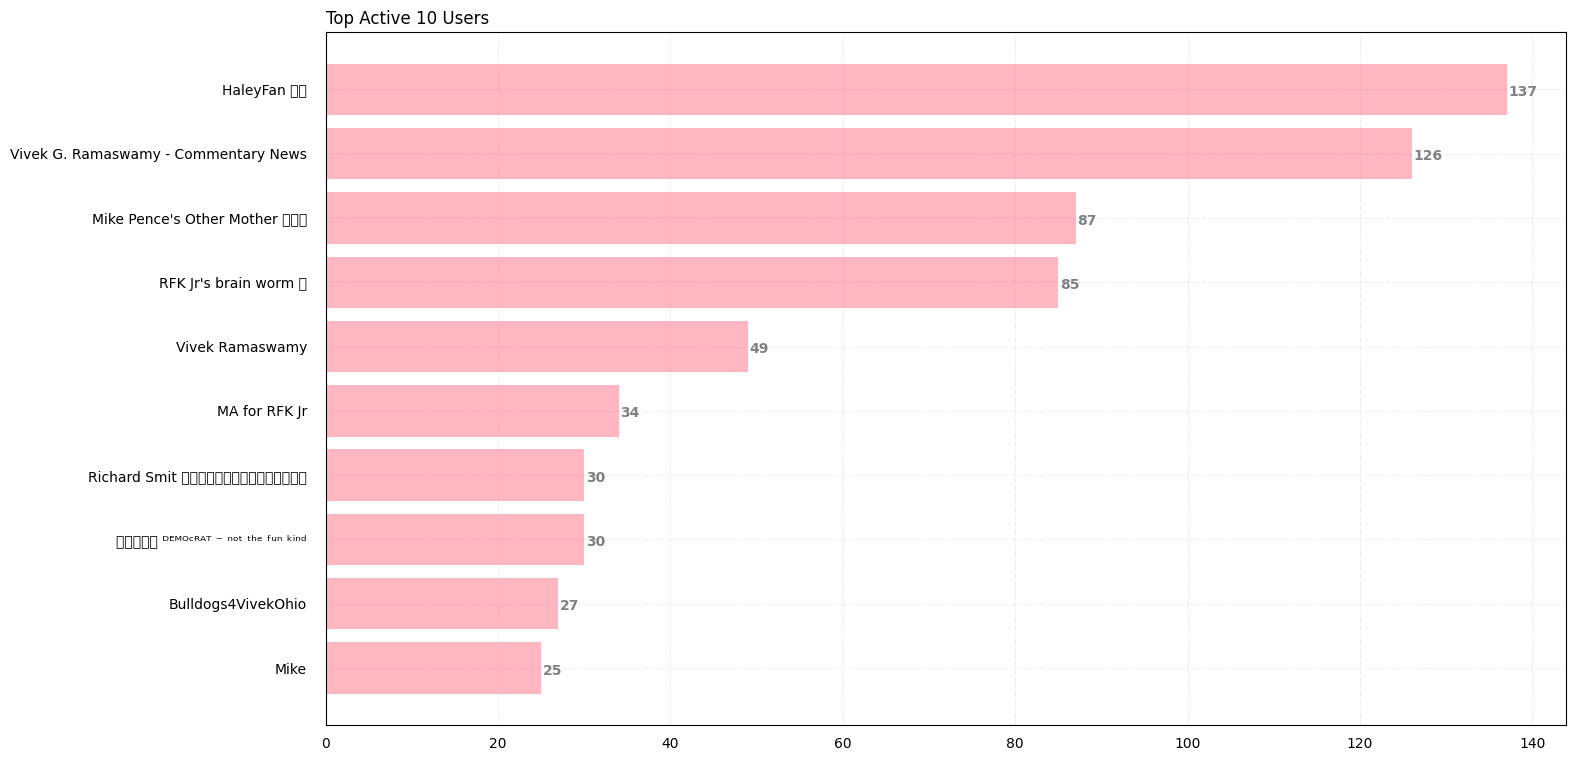

In [30]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))
plt.rcParams['font.family'] = 'DejaVu Sans'

# Horizontal Bar Plot
ax.barh(usernames[:10], count_usernames[:10], color='lightpink')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top Active 10 Users', loc='left')

# Show Plot
plt.show()